# LINK Info Dashboard

In [1]:
import os
import sys

import dotenv
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import HelixirQueryApi

## Create Query Api Client


In [3]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = HelixirQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

## Get LINK Token by its Contract

In [4]:
token_contract = '0x514910771AF9Ca656af840dff83E8264EcF986CA'
token_query = """SELECT *
    FROM exchange.eth.raw.tokens
    WHERE contract = '{contract}';""".format(contract=token_contract)

token = client.get_data_response(token_query)
token

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,active,burned,chain_id,contract,decimals,id,name,symbol,total_supply
0,True,6.1372085021389963,1,0x514910771AF9Ca656af840dff83E8264EcF986CA,18,7,ChainLink Token,LINK,1000000000


## Get Number of Swaps for LINK

In [5]:
swaps_number_query = """SELECT bucket as time, sum(count) as swaps_num
FROM exchange.eth.series.swap_number_ticks_daily
WHERE bucket >= now() - interval '12' month
and (token0_id = {token_id} or token1_id = {token_id})
group by 1
order by 1;""".format(token_id=token['id'][0])

swaps_num = client.get_data_response(swaps_number_query)
swaps_num['time'] = pd.to_datetime(swaps_num['time'])
swaps_num.set_index('time', inplace=True)
swaps_num['swaps_num'] = pd.to_numeric(swaps_num['swaps_num'])
swaps_num

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,swaps_num
time,
2022-03-07 00:00:00+00:00,414
2022-03-08 00:00:00+00:00,405
2022-03-09 00:00:00+00:00,304
2022-03-10 00:00:00+00:00,274
2022-03-11 00:00:00+00:00,241
...,...
2023-03-01 00:00:00+00:00,351
2023-03-02 00:00:00+00:00,354
2023-03-03 00:00:00+00:00,420


## Holders of LINK

In [6]:
holders_query = """SELECT count(*) as holders
from exchange.eth.series.balances
where token = {token_id}
  and cast(balance as decimal(38, 18)) > 0;""".format(token_id=token['id'][0])

holders = client.get_data_response(holders_query)
holders


Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,holders
0,356704


## Market Capitalization

In [7]:
market_cap_query = """SELECT *
from exchange.eth.raw.market_capitalizations
where token_id = {token_id};""".format(token_id=token['id'][0])

market_cap = client.get_data_response(market_cap_query)
market_cap['market_cap'] = pd.to_numeric(market_cap['market_cap'])
market_cap['price_stable'] = pd.to_numeric(market_cap['price_stable'])
market_cap['price_peg'] = pd.to_numeric(market_cap['price_peg'])

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

In [8]:
print("Recent price of {token}: ${price_stable} or equivalently {price_peg} ETH".format(token=token['symbol'][0],
                                                                                        price_stable=
                                                                                        market_cap['price_stable'][0],
                                                                                        price_peg=
                                                                                        market_cap['price_peg'][0]))
print("Market Capitalization: ${market_cap}".format(market_cap=market_cap['market_cap'][0]))
print("And currently there is {holders} holders of {token}.".format(holders=holders['holders'][0],
                                                                    token=token['symbol'][0]))

Recent price of LINK: $6.916674920640397 or equivalently 0.004414473383558 ETH
Market Capitalization: $6916674878.19132
And currently there is 356704 holders of LINK.


## Get TOHLCV for LINK

In [9]:
tohlcv_query = """SELECT p.bucket as time, open_stable, high_stable, low_stable, close_stable, v.volume
FROM exchange.eth.series.price_ticks_daily p
         join exchange.eth.series.volume_ticks_daily v
              on (p.bucket = v.bucket and p.token_id = v.token_id and p.platform_id = v.platform_id)
WHERE p.token_id = {token_id}
  and p.bucket >= now() - interval '12' month
  and p.platform_id = 1
ORDER BY time;""".format(token_id=token['id'][0])

tohlcv_resp = client.get_data_response(tohlcv_query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time', inplace=True)
tohlcv_resp['open_stable'] = pd.to_numeric(tohlcv_resp['open_stable'])
tohlcv_resp['high_stable'] = pd.to_numeric(tohlcv_resp['high_stable'])
tohlcv_resp['low_stable'] = pd.to_numeric(tohlcv_resp['low_stable'])
tohlcv_resp['close_stable'] = pd.to_numeric(tohlcv_resp['close_stable'])
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close_stable,high_stable,low_stable,open_stable,volume
time,,,,,
2022-03-07 00:00:00+00:00,12.816674,13.576710,12.486655,13.152220,54957.7554347709054490
2022-03-08 00:00:00+00:00,13.069314,13.493957,12.670111,12.804683,49296.5279908476115591
2022-03-09 00:00:00+00:00,13.886584,14.379942,13.112718,13.112718,16163.9610884303655125
2022-03-10 00:00:00+00:00,13.220810,14.050729,12.882410,14.002837,23775.1257136481062012
2022-03-11 00:00:00+00:00,13.057144,13.535923,12.806655,13.038760,25998.7004235380332810
...,...,...,...,...,...
2023-03-01 00:00:00+00:00,7.487131,7.509939,7.193581,7.210982,3762.9144078853950880
2023-03-02 00:00:00+00:00,7.268035,7.580278,7.199256,7.474424,3251.2467215723656510
2023-03-03 00:00:00+00:00,6.898953,7.053375,6.765071,7.053375,7148.0333802582681729


## Plot stats against price

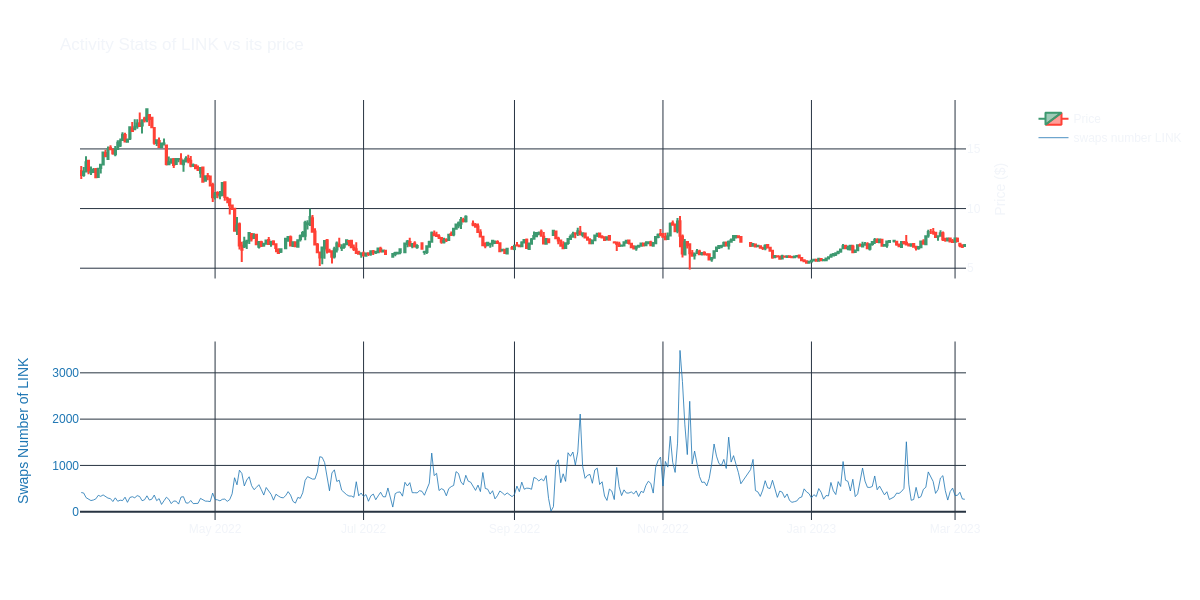

In [10]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

candlestick = go.Candlestick(
    x=tohlcv_resp.index.to_list(),
    open=tohlcv_resp['open_stable'],
    high=tohlcv_resp['high_stable'],
    low=tohlcv_resp['low_stable'],
    close=tohlcv_resp['close_stable'],
    name="Price"
)

swaps_p = go.Scatter(x=swaps_num.index.to_list(),
                     y=swaps_num['swaps_num'],
                     name="swaps number {token}".format(token=token['symbol'][0]),
                     mode='lines',
                     line=dict(width=0.8, color="#1f77b4"),
                     )

fig.add_trace(candlestick, row=1, col=1)
fig.add_trace(swaps_p, row=2, col=1)

fig.update_layout(
    width=1200, height=600,
    title="Activity Stats of {token} vs its price".format(token=token["symbol"][0]),
    xaxis_rangeslider_visible=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        title="Price ($)",
        anchor="x",
        overlaying="y",
        side="right",
        tickmode="sync",
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=1.25
    )
)

fig.update_yaxes(title="Swaps Number of {token}".format(token=token['symbol'][0]),
                 titlefont=dict(
                     color="#1f77b4"
                 ),
                 tickfont=dict(
                     color="#1f77b4"
                 ),
                 tickmode="sync",
                 row=2, col=1)

fig.show("png")